<a href="https://colab.research.google.com/github/ktaran-jeet/deepVision-ImageClassification/blob/main/VGG11.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# VGGNet:
VGGNet is the 1st runner-up, not the winner of the ILSVRC-2014 in the classification task.

### The architecture
During training, the input to our ConvNets is a fixed-size 224 × 224 RGB image. The only preprocessing we do is subtracting the mean RGB value, computed on the training set, from each pixel. The image is passed through a stack of convolutional (conv.) layers. All hidden layers are equipped with the rectification (ReLU (Krizhevsky et al., 2012)) non-linearity. The width of conv. layers (the number of channels) is rather small, starting from 64 in the first layer and then increasing by a factor of 2 after each max-pooling layer, until it reaches 512. Number of layers depend on VGG-11, VGG-11 (LRN), VGG-13, VGG-16 (Conv1), VGG-16 and VGG-19 architechure.

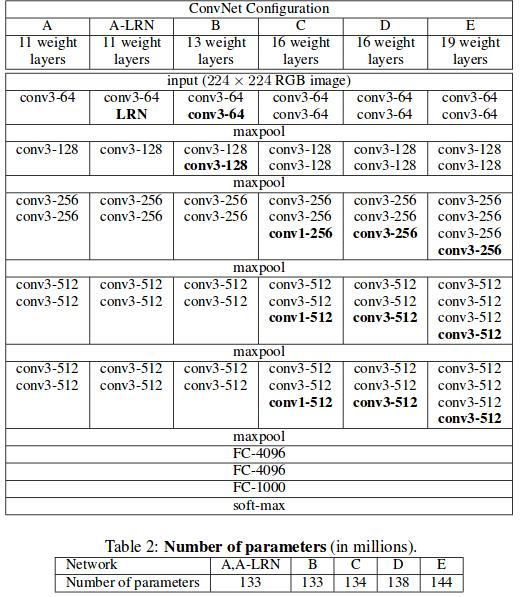

In [ ]:
import sys
import matplotlib,numpy
import torch

# Printing versions
print("Python version:", sys.version)
print("Matplotlib version:", matplotlib.__version__)
print("Numpy version:", numpy.__version__)
print("PyTorch version:", torch.__version__)

Python version: 3.12.2 (tags/v3.12.2:6abddd9, Feb  6 2024, 21:26:36) [MSC v.1937 64 bit (AMD64)]
Matplotlib version: 3.9.2
Numpy version: 1.26.4
PyTorch version: 2.5.1+cpu


## VGG11 Implementation on MNIST dataset
#### Data Loading and pre-processing:

MNIST dataset: Dataset of 60,000 28x28 digits training images, labeled over 10 categories, and 10,000 test images.


In [ ]:
from torch.utils.data import DataLoader,Subset
from torchvision import datasets, transforms
import random

#Transformations:
transform32 = transforms.Compose([
    transforms.Resize(32),
    transforms.ToTensor(),
    transforms.Normalize((0.5,),(0.5)),
])

transform28 = transforms.Compose([
    transforms.Resize(28),
    transforms.ToTensor(),
    transforms.Normalize((0.5,),(0.5)),
])

transformhp = transforms.Compose([
    transforms.Resize(32),
    transforms.RandomHorizontalFlip(p=1),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

transformvp = transforms.Compose([
    transforms.Resize(32),
    transforms.RandomVerticalFlip(p=1),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

noise_transforms1 = transforms.Compose([
        transforms.Resize(32),
        transforms.ToTensor(),
        transforms.Lambda(lambda x: x + torch.sqrt(torch.tensor(0.01)) * torch.randn_like(x)),
        transforms.Normalize((0.5,), (0.5,))
])

noise_transforms2 = transforms.Compose([
        transforms.Resize(32),
        transforms.ToTensor(),
        transforms.Lambda(lambda x: x + torch.sqrt(torch.tensor(0.1)) * torch.randn_like(x)),
        transforms.Normalize((0.5,), (0.5,))
])

noise_transforms3 = transforms.Compose([
        transforms.Resize(32),
        transforms.ToTensor(),
        transforms.Lambda(lambda x: x + torch.sqrt(torch.tensor(1.0)) * torch.randn_like(x)),
        transforms.Normalize((0.5,), (0.5,))
])

#data augmentation transformations
transform_augment = transforms.Compose([
    transforms.Resize(32),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.RandomVerticalFlip(p=0.5),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

#For CNN:
train_dataset1 = datasets.MNIST(root='./data', train=True, transform=transform32, download=True)
test_dataset1 = datasets.MNIST(root='./data', train=False, transform=transform32, download=True)

#For MLP
train_dataset2 = datasets.MNIST(root='./data', train=True, transform=transform28, download=True)
test_dataset2 = datasets.MNIST(root='./data', train=False, transform=transform28, download=True)

def get_sample_indices(dataset, num_samples_per_class, num_classes=10):
    subset_indices = []
    for class_id in range(num_classes):
        class_indices = (dataset.targets == class_id).nonzero(as_tuple=True)[0]
        selected_indices = class_indices[:num_samples_per_class]
        subset_indices.extend(selected_indices)
    return subset_indices


training_sample_indices = get_sample_indices(train_dataset1, num_samples_per_class=600, num_classes=10)
test_sample_indices = get_sample_indices(test_dataset1, num_samples_per_class=100, num_classes=10)

In [ ]:
subset_train_dataset1 = Subset(train_dataset1, training_sample_indices)
subset_test_dataset1 = Subset(test_dataset1, test_sample_indices)

train_loader1 = DataLoader(subset_train_dataset1, batch_size=64, shuffle=True)
test_loader1 = DataLoader(subset_test_dataset1, batch_size=64, shuffle=True)

print(len(subset_train_dataset1))
print(len(subset_test_dataset1))

6000
1000


## Model Implementation using PyTorch

In [ ]:
#Define VG11 model:
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import itertools

class VGG11(nn.Module):
    def __init__(self):
        super(VGG11, self).__init__()
        self.convlayers = nn.Sequential(
            nn.Conv2d(1, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(256, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )

        self.linearlayers = nn.Sequential(
            nn.Linear(512, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(4096, 10),
        )

    def forward(self, x):
        x = self.convlayers(x)
        x = torch.flatten(x,1)
        x = self.linearlayers(x)
        return x

def train(model, optimizer, criterion, train_loader, test_loader, epochs=1):
    train_losses, test_losses, train_accuracies, test_accuracies = ([] for _ in range(4))

    for epoch in range(epochs):
        model.train()
        train_loss = 0.0
        correct=0
        total=0
        for images, labels in train_loader:
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()

            _, predicted = torch.max(outputs,1)
            total += labels.size(0)
            correct += (predicted==labels).sum().item()

        train_accuracy = (correct*100)/total
        train_loss /= len(train_loader)
        train_losses.append(train_loss)
        train_accuracies.append(train_accuracy)


        model.eval()
        test_loss = 0.0
        correct=0
        total=0
        with torch.no_grad():
            for images,labels in test_loader:
                outputs = model(images)
                loss = criterion(outputs, labels)
                test_loss += loss.item()

                _, predicted = torch.max(outputs,1)
                total += labels.size(0)
                correct += (predicted==labels).sum().item()

        test_accuracy = (correct*100)/total
        test_loss /= len(test_loader)
        test_losses.append(test_loss)
        test_accuracies.append(test_accuracy)

        print(f"Epoch [{epoch + 1}/{epochs}], Train Loss: {train_loss:.4f}, Train Acc: {train_accuracy:.2f}%, Test Loss: {test_loss:.4f}, Test Acc: {test_accuracy:.2f}%")


    return train_losses, test_losses, train_accuracies, test_accuracies

def evaluate_model(model, loader):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in loader:
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    accuracy = 100 * correct / total
    return accuracy

def plot_comparison_metrics(metrics_list, num_epochs, model_names=None):
    # Define colors and markers for plotting
    colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k']
    markers = ['o-', 's-', '^-', 'D-', 'v-', 'x-', 'p-']
    color_marker_cycle = itertools.cycle(zip(colors, markers))

    if model_names is None:
        model_names = [f"Model {i+1}" for i in range(len(metrics_list))]

    epochs = range(1, num_epochs + 1)
    plt.figure(figsize=(12, 10))

    # Test Accuracy vs Epochs
    plt.subplot(2, 2, 1)
    for metrics, model_name in zip(metrics_list, model_names):
        color, marker = next(color_marker_cycle)
        plt.plot(epochs, metrics[3], color + marker, label=f'{model_name} Test Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy (%)')
    plt.title('Test Accuracy vs Epochs')
    plt.legend()

    # Train Accuracy vs Epochs
    plt.subplot(2, 2, 2)
    for metrics, model_name in zip(metrics_list, model_names):
        color, marker = next(color_marker_cycle)
        plt.plot(epochs, metrics[2], color + marker, label=f'{model_name} Train Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy (%)')
    plt.title('Train Accuracy vs Epochs')
    plt.legend()

    # Test Loss vs Epochs
    plt.subplot(2, 2, 3)
    for metrics, model_name in zip(metrics_list, model_names):
        color, marker = next(color_marker_cycle)
        plt.plot(epochs, metrics[1], color + marker, label=f'{model_name} Test Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Test Loss vs Epochs')
    plt.legend()

    # Train Loss vs Epochs
    plt.subplot(2, 2, 4)
    for metrics, model_name in zip(metrics_list, model_names):
        color, marker = next(color_marker_cycle)
        plt.plot(epochs, metrics[0], color + marker, label=f'{model_name} Train Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Train Loss vs Epochs')
    plt.legend()

    plt.tight_layout()
    plt.show()

#### Model training using SGD optimizer:

Epoch [1/20], Train Loss: 1.3534, Train Acc: 63.38%, Test Loss: 0.2631, Test Acc: 93.90%
Epoch [2/20], Train Loss: 0.1627, Train Acc: 96.57%, Test Loss: 0.1313, Test Acc: 96.20%
Epoch [3/20], Train Loss: 0.0633, Train Acc: 98.67%, Test Loss: 0.0857, Test Acc: 97.60%
Epoch [4/20], Train Loss: 0.0277, Train Acc: 99.58%, Test Loss: 0.0754, Test Acc: 98.10%
Epoch [5/20], Train Loss: 0.0141, Train Acc: 99.93%, Test Loss: 0.0689, Test Acc: 98.00%
Epoch [6/20], Train Loss: 0.0086, Train Acc: 99.98%, Test Loss: 0.0605, Test Acc: 97.90%
Epoch [7/20], Train Loss: 0.0058, Train Acc: 100.00%, Test Loss: 0.0612, Test Acc: 98.10%
Epoch [8/20], Train Loss: 0.0045, Train Acc: 100.00%, Test Loss: 0.0613, Test Acc: 98.00%
Epoch [9/20], Train Loss: 0.0034, Train Acc: 100.00%, Test Loss: 0.0599, Test Acc: 97.80%
Epoch [10/20], Train Loss: 0.0027, Train Acc: 100.00%, Test Loss: 0.0572, Test Acc: 98.00%
Epoch [11/20], Train Loss: 0.0025, Train Acc: 100.00%, Test Loss: 0.0572, Test Acc: 98.00%
Epoch [12/20],

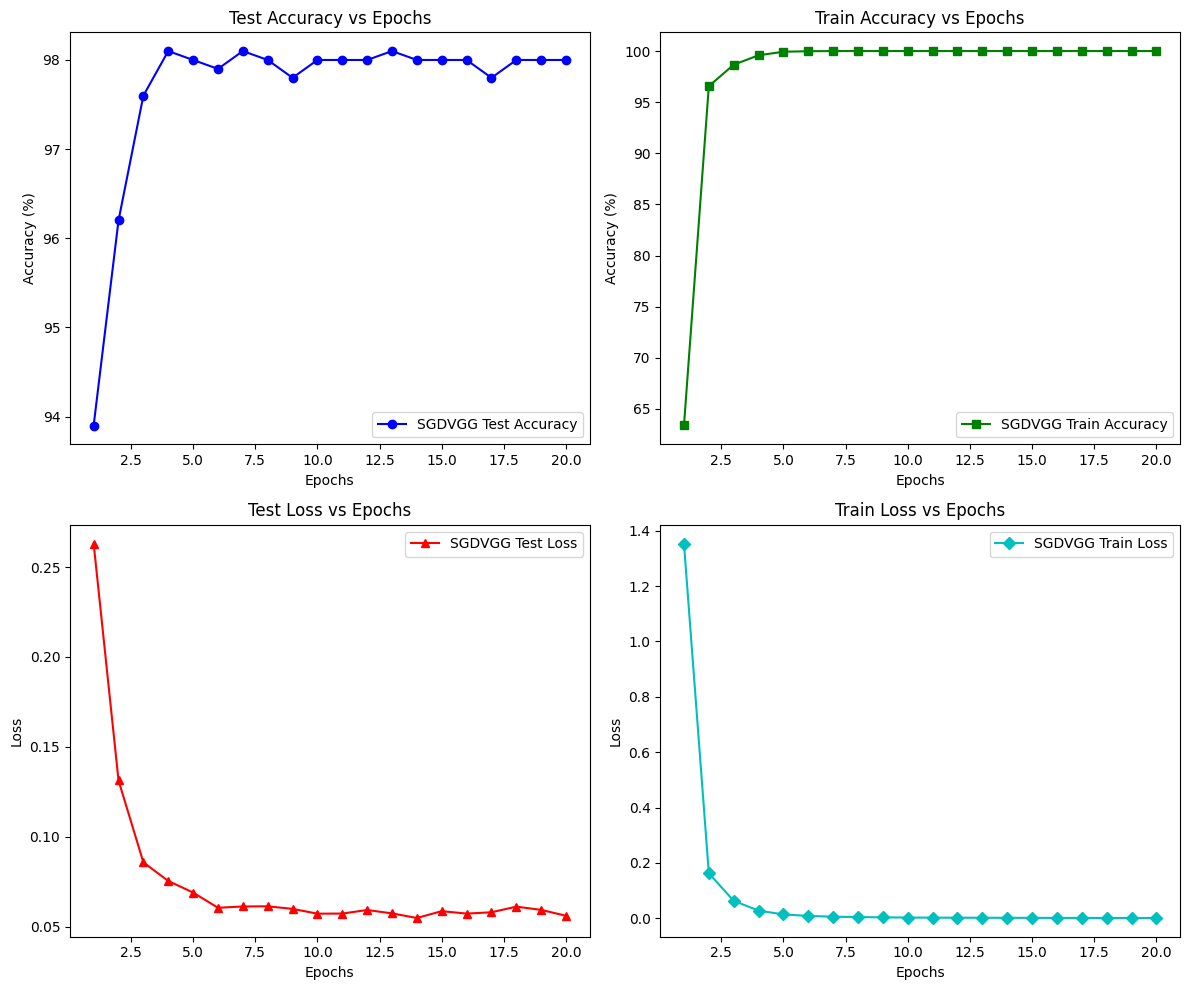

In [ ]:
vggmodel = VGG11()
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(vggmodel.parameters(), lr=0.001, momentum=0.9)
num_epochs = 20

metrics = train(vggmodel, optimizer, criterion, train_loader1, test_loader1, num_epochs)
torch.save(vggmodel.state_dict(), "sgdvgg.pth")
plot_comparison_metrics([metrics],num_epochs,["SGDVGG"])

#### Testing model accuracy with horizontal,vertical flips and gaussian noise:

In [ ]:
#evaluate horizontal-flip testset:
#Note:test_sample_indices are the same as previous so the same images used for testing earlier are used for flip transforms:
test_datasethf = datasets.MNIST(root='./data', train=False, transform=transformhp, download=True)
subset_test_datasethf = Subset(test_datasethf, test_sample_indices)
test_loaderhf = DataLoader(subset_test_datasethf, batch_size=64, shuffle=True)

print(evaluate_model(vggmodel, test_loaderhf))

41.5


In [ ]:
#evaluate vertical-flip testset:
test_datasetvf = datasets.MNIST(root='./data', train=False, transform=transformvp, download=True)
subset_test_datasetvf = Subset(test_datasetvf, test_sample_indices)
test_loadervf = DataLoader(subset_test_datasetvf, batch_size=64, shuffle=True)

print(evaluate_model(vggmodel, test_loadervf))

41.5


In [ ]:
#evaluate Gaussian noise variance: 0.01
test_datasetn1 = datasets.MNIST(root='./data', train=False, transform=noise_transforms1, download=True)
subset_test_datasetn1 = Subset(test_datasetn1, test_sample_indices)
test_loadern1 = DataLoader(subset_test_datasetn1, batch_size=64, shuffle=True)

print(evaluate_model(vggmodel, test_loadern1))

87.0


In [ ]:
#evaluate Gaussian noise variance: 0.1
test_datasetn2 = datasets.MNIST(root='./data', train=False, transform=noise_transforms2, download=True)
subset_test_datasetn2 = Subset(test_datasetn2, test_sample_indices)
test_loadern2 = DataLoader(subset_test_datasetn2, batch_size=64, shuffle=True)

print(evaluate_model(vggmodel, test_loadern2))

10.0


In [ ]:
#evaluate Gaussian noise variance: 1.0
test_datasetn3 = datasets.MNIST(root='./data', train=False, transform=noise_transforms3, download=True)
subset_test_datasetn3 = Subset(test_datasetn3, test_sample_indices)
test_loadern3 = DataLoader(subset_test_datasetn3, batch_size=64, shuffle=True)

print(evaluate_model(vggmodel, test_loadern3))

10.0


#### Retraining model on aumented data using flips and noise in the training images

In [ ]:
#Retrain on augemented data:
augmented_train_dataset = datasets.MNIST(root='./data', train=True, transform=transform_augment, download=True)
augmented_test_dataset = datasets.MNIST(root='./data', train=False, transform=transform_augment, download=True)

subsetaug_train_dataset = Subset(augmented_train_dataset, training_sample_indices)
subsetaug_test_dataset = Subset(augmented_test_dataset, test_sample_indices)

train_loaderaug = DataLoader(subsetaug_train_dataset, batch_size=64, shuffle=True)
test_loaderaug = DataLoader(subsetaug_test_dataset, batch_size=64, shuffle=True)

print(len(subsetaug_train_dataset))
print(len(subsetaug_test_dataset))

6000
1000


Epoch [1/20], Train Loss: 1.8351, Train Acc: 36.05%, Test Loss: 1.0742, Test Acc: 62.20%
Epoch [2/20], Train Loss: 0.7069, Train Acc: 77.97%, Test Loss: 0.4773, Test Acc: 83.80%
Epoch [3/20], Train Loss: 0.3830, Train Acc: 88.33%, Test Loss: 0.6056, Test Acc: 79.50%
Epoch [4/20], Train Loss: 0.2812, Train Acc: 91.40%, Test Loss: 0.3104, Test Acc: 90.10%
Epoch [5/20], Train Loss: 0.2049, Train Acc: 94.28%, Test Loss: 0.4400, Test Acc: 85.90%
Epoch [6/20], Train Loss: 0.1791, Train Acc: 94.52%, Test Loss: 0.3879, Test Acc: 88.60%
Epoch [7/20], Train Loss: 0.1564, Train Acc: 95.23%, Test Loss: 0.3285, Test Acc: 89.90%
Epoch [8/20], Train Loss: 0.1339, Train Acc: 95.65%, Test Loss: 0.1889, Test Acc: 93.80%
Epoch [9/20], Train Loss: 0.1153, Train Acc: 96.55%, Test Loss: 0.2110, Test Acc: 93.80%
Epoch [10/20], Train Loss: 0.0898, Train Acc: 97.23%, Test Loss: 0.2048, Test Acc: 93.80%
Epoch [11/20], Train Loss: 0.0900, Train Acc: 97.10%, Test Loss: 0.1723, Test Acc: 94.60%
Epoch [12/20], Trai

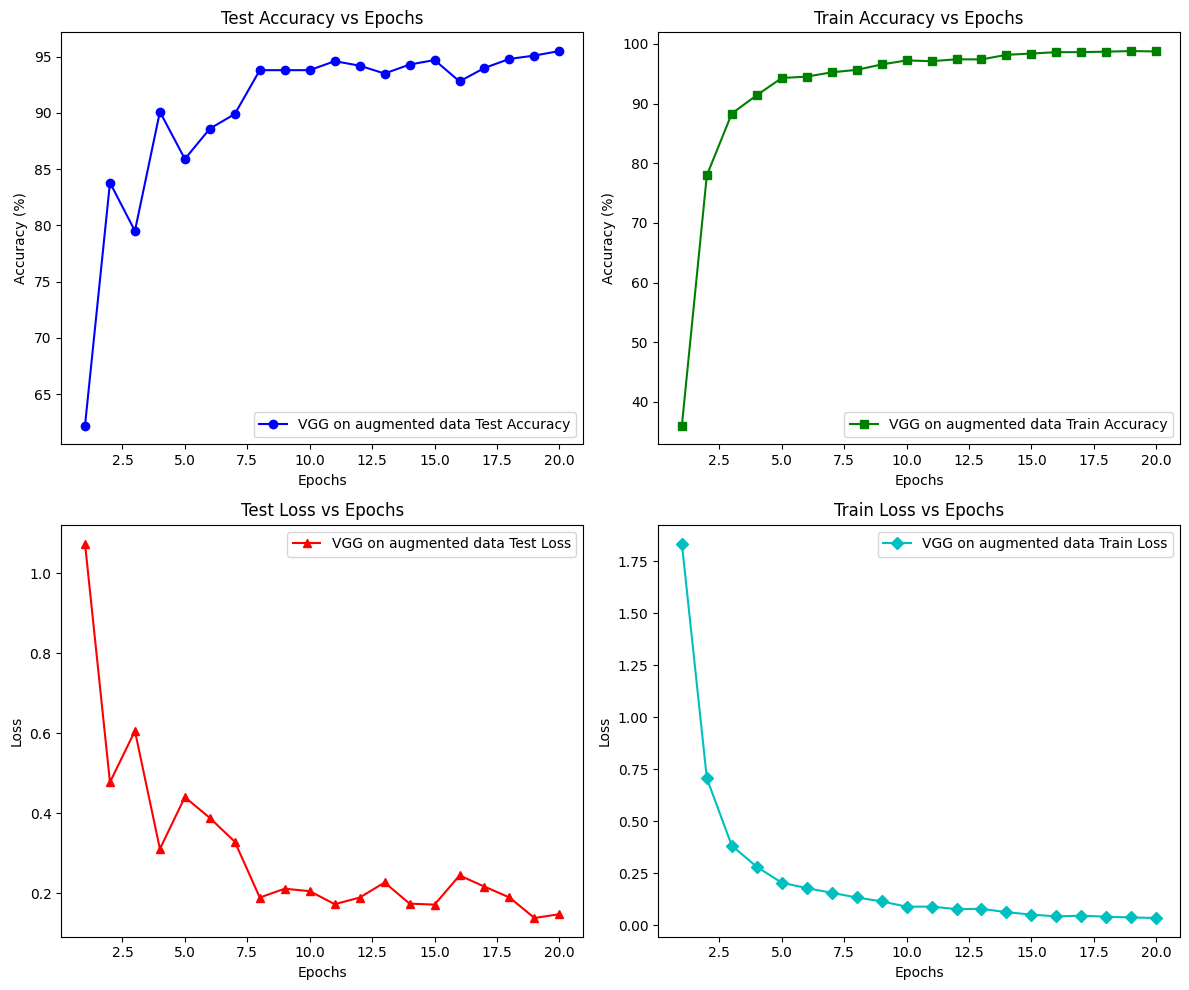

In [ ]:
vggmodelaug = VGG11()
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(vggmodelaug.parameters(), lr=0.001, momentum=0.9)
num_epochs = 20

metrics_aug = train(vggmodelaug, optimizer, criterion, train_loaderaug, test_loaderaug, num_epochs)
torch.save(vggmodelaug.state_dict(), "vggmodelaug.pth")
plot_comparison_metrics([metrics_aug],num_epochs,["VGG on augmented data"])

In [ ]:
#Testing the augmeneted model:
print("Accuracy for Horizontal flip dataset",evaluate_model(vggmodelaug, test_loaderhf))
print("Accuracy for Vertical flip dataset",evaluate_model(vggmodelaug, test_loadervf))
print("Accuracy for dataset with Gaussian Noise, variance=0.001",evaluate_model(vggmodelaug, test_loadern1))
print("Accuracy for dataset with Gaussian Noise, variance=0.01",evaluate_model(vggmodelaug, test_loadern2))
print("Accuracy for dataset with Gaussian Noise, variance=1.0",evaluate_model(vggmodelaug, test_loadern3))

Accuracy for Horizontal flip dataset 95.7
Accuracy for Vertical flip dataset 95.3
Accuracy for dataset with Gaussian Noise, variance=0.001 87.3
Accuracy for dataset with Gaussian Noise, variance=0.01 30.6
Accuracy for dataset with Gaussian Noise, variance=1.0 17.5


### Training using adaDelta Optimizer:

Epoch [1/20], Train Loss: 2.1056, Train Acc: 18.42%, Test Loss: 1.7242, Test Acc: 22.50%
Epoch [2/20], Train Loss: 1.7238, Train Acc: 25.95%, Test Loss: 1.4546, Test Acc: 36.40%
Epoch [3/20], Train Loss: 1.3208, Train Acc: 44.78%, Test Loss: 1.4730, Test Acc: 46.20%
Epoch [4/20], Train Loss: 0.8115, Train Acc: 67.58%, Test Loss: 1.0417, Test Acc: 65.60%
Epoch [5/20], Train Loss: 0.5185, Train Acc: 80.68%, Test Loss: 0.4140, Test Acc: 83.90%
Epoch [6/20], Train Loss: 0.3279, Train Acc: 91.28%, Test Loss: 1.1126, Test Acc: 79.20%
Epoch [7/20], Train Loss: 0.1858, Train Acc: 95.65%, Test Loss: 0.1703, Test Acc: 95.50%
Epoch [8/20], Train Loss: 0.1290, Train Acc: 96.75%, Test Loss: 0.1650, Test Acc: 96.30%
Epoch [9/20], Train Loss: 0.1496, Train Acc: 96.92%, Test Loss: 0.1899, Test Acc: 95.80%
Epoch [10/20], Train Loss: 0.0774, Train Acc: 98.15%, Test Loss: 0.0893, Test Acc: 97.40%
Epoch [11/20], Train Loss: 0.0590, Train Acc: 98.58%, Test Loss: 0.1048, Test Acc: 97.80%
Epoch [12/20], Trai

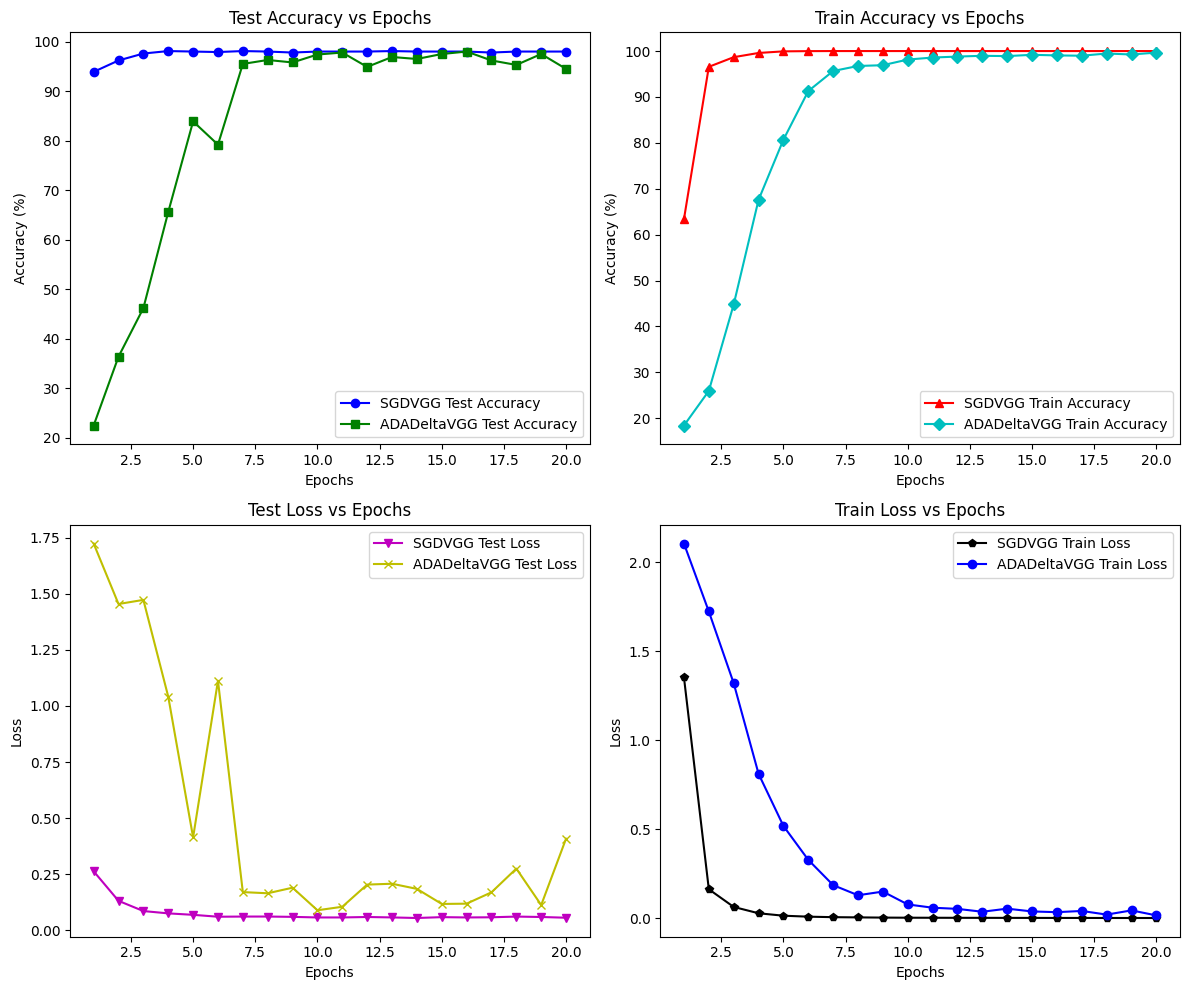

In [ ]:
#Training with adaDelta:
vggmodelada = VGG11()
criterion = nn.CrossEntropyLoss()
optimizer_adadelta = optim.Adadelta(vggmodelada.parameters(), lr=1.0, weight_decay=1e-5)
num_epochs = 20

metrics_ada = train(vggmodelada, optimizer_adadelta, criterion, train_loader1, test_loader1, num_epochs)
torch.save(vggmodelada.state_dict(), "vggmodelada.pth")
plot_comparison_metrics([metrics, metrics_ada],num_epochs,["SGDVGG","ADADeltaVGG"])

#### Training using Adam optimizer:

Epoch [1/20], Train Loss: 1.8247, Train Acc: 28.42%, Test Loss: 1.6388, Test Acc: 33.80%
Epoch [2/20], Train Loss: 1.0662, Train Acc: 55.82%, Test Loss: 0.7122, Test Acc: 74.00%
Epoch [3/20], Train Loss: 0.4208, Train Acc: 85.80%, Test Loss: 0.2197, Test Acc: 93.30%
Epoch [4/20], Train Loss: 0.2007, Train Acc: 94.33%, Test Loss: 0.3178, Test Acc: 91.20%
Epoch [5/20], Train Loss: 0.1646, Train Acc: 95.75%, Test Loss: 0.4688, Test Acc: 88.90%
Epoch [6/20], Train Loss: 0.1219, Train Acc: 96.98%, Test Loss: 0.1904, Test Acc: 95.70%
Epoch [7/20], Train Loss: 0.1255, Train Acc: 96.68%, Test Loss: 0.1243, Test Acc: 96.90%
Epoch [8/20], Train Loss: 0.0833, Train Acc: 97.90%, Test Loss: 0.1937, Test Acc: 95.60%
Epoch [9/20], Train Loss: 0.0840, Train Acc: 97.80%, Test Loss: 0.3191, Test Acc: 95.50%
Epoch [10/20], Train Loss: 0.1010, Train Acc: 97.60%, Test Loss: 0.2788, Test Acc: 94.80%
Epoch [11/20], Train Loss: 0.0930, Train Acc: 97.80%, Test Loss: 0.1541, Test Acc: 96.50%
Epoch [12/20], Trai

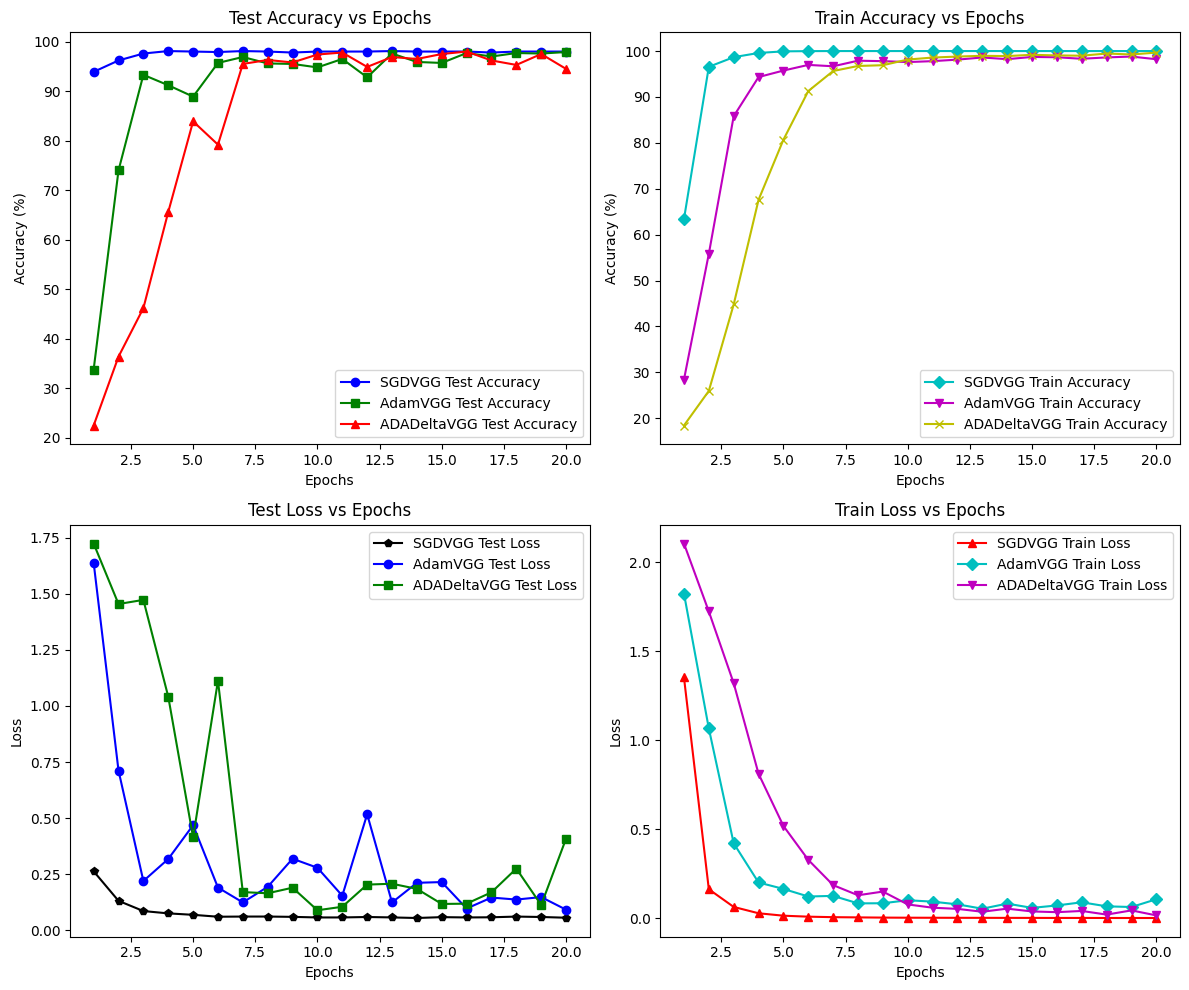

In [ ]:
#Training with optimizer Adam:
vggmodeladam = VGG11()
criterion = nn.CrossEntropyLoss()
optimizer_adam = optim.Adam(vggmodeladam.parameters(), lr=0.001, weight_decay=1e-5)
num_epochs = 20

metrics_adam = train(vggmodeladam, optimizer_adam, criterion, train_loader1, test_loader1, num_epochs)
torch.save(vggmodeladam.state_dict(), "vggmodeladam.pth")
plot_comparison_metrics([metrics, metrics_adam, metrics_ada],num_epochs,["SGDVGG","AdamVGG", "ADADeltaVGG"])

#### Replacing ReLU with sigmoid activation:
The sigmoid function squashes input values to a range between 0 and 1. For very large or very small inputs, the gradient of the sigmoid function becomes very small (close to zero). That's why using sigmoid in initial layers should reduce accuracy even with a network like VGG.

In [ ]:
#Replace ReLU with Sigmoid:
class VGGSigmoid(nn.Module):
    def __init__(self):
        super(VGGSigmoid, self).__init__()
        self.convlayers = nn.Sequential(
            nn.Conv2d(1, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.Sigmoid(),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.Sigmoid(),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.Sigmoid(),
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.Sigmoid(),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(256, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.Sigmoid(),
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.Sigmoid(),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.Sigmoid(),
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.Sigmoid(),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )

        self.linearlayers = nn.Sequential(
            nn.Linear(512, 4096),
            nn.Sigmoid(),
            nn.Dropout(0.5),
            nn.Linear(4096, 4096),
            nn.Sigmoid(),
            nn.Dropout(0.5),
            nn.Linear(4096, 10),
        )

    def forward(self, x):
        x = self.convlayers(x)
        x = torch.flatten(x,1)
        x = self.linearlayers(x)
        return x


Epoch [1/20], Train Loss: 2.3775, Train Acc: 9.88%, Test Loss: 2.3380, Test Acc: 10.00%
Epoch [2/20], Train Loss: 2.3737, Train Acc: 10.20%, Test Loss: 2.3342, Test Acc: 10.00%
Epoch [3/20], Train Loss: 2.3850, Train Acc: 9.98%, Test Loss: 2.3600, Test Acc: 10.00%
Epoch [4/20], Train Loss: 2.3854, Train Acc: 10.28%, Test Loss: 2.3352, Test Acc: 10.00%
Epoch [5/20], Train Loss: 2.3829, Train Acc: 9.67%, Test Loss: 2.3763, Test Acc: 10.00%
Epoch [6/20], Train Loss: 2.3742, Train Acc: 10.13%, Test Loss: 2.3346, Test Acc: 10.00%
Epoch [7/20], Train Loss: 2.3744, Train Acc: 9.87%, Test Loss: 2.3518, Test Acc: 20.00%
Epoch [8/20], Train Loss: 2.3738, Train Acc: 10.15%, Test Loss: 2.3212, Test Acc: 10.00%
Epoch [9/20], Train Loss: 2.3588, Train Acc: 10.33%, Test Loss: 2.3049, Test Acc: 10.00%
Epoch [10/20], Train Loss: 2.3700, Train Acc: 10.00%, Test Loss: 2.3243, Test Acc: 10.00%
Epoch [11/20], Train Loss: 2.3654, Train Acc: 10.63%, Test Loss: 2.3165, Test Acc: 17.20%
Epoch [12/20], Train Lo

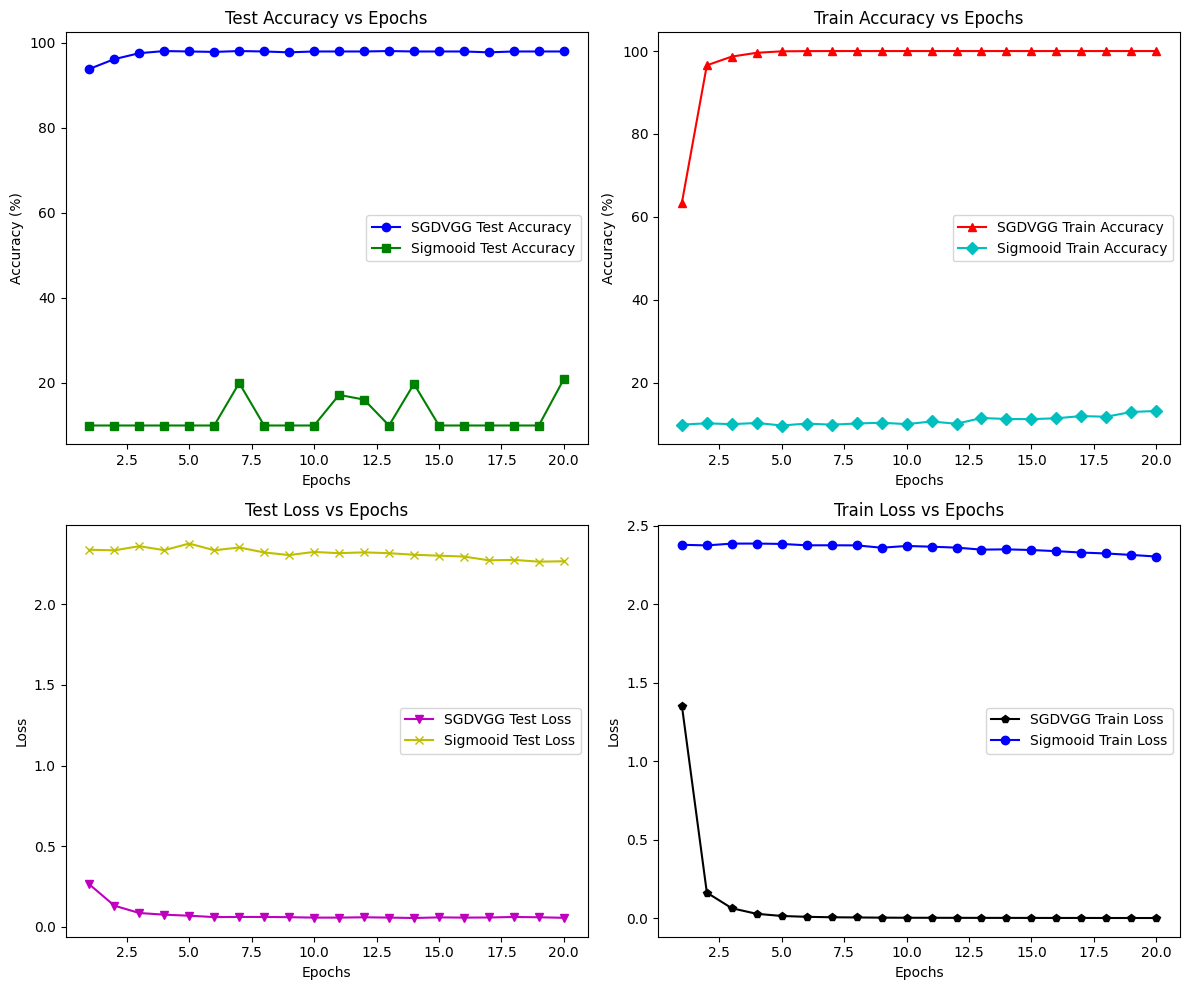

In [ ]:
vggsigmoid = VGGSigmoid()
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(vggsigmoid.parameters(), lr=0.001, momentum=0.9)
num_epochs = 20

metrics_sigmoid = train(vggsigmoid, optimizer, criterion, train_loader1, test_loader1, num_epochs)
torch.save(vggsigmoid.state_dict(), "vggmodelsigmoid.pth")
plot_comparison_metrics([metrics, metrics_sigmoid],num_epochs,["SGDVGG","Sigmooid"])

#### Studying the effect of Dropout layers in VGG11:

In [ ]:
#Removing Dropout layers from VGG:
class VGGWithoutDropout(nn.Module):
    def __init__(self):
        super(VGGWithoutDropout, self).__init__()
        self.convlayers = nn.Sequential(
            nn.Conv2d(1, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(256, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )

        self.linearlayers = nn.Sequential(
            nn.Linear(512, 4096),
            nn.ReLU(inplace=True),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Linear(4096, 10),
        )

    def forward(self, x):
        x = self.convlayers(x)
        x = torch.flatten(x,1)
        x = self.linearlayers(x)
        return x



Epoch [1/20], Train Loss: 1.1063, Train Acc: 75.27%, Test Loss: 0.2260, Test Acc: 94.80%
Epoch [2/20], Train Loss: 0.1213, Train Acc: 97.27%, Test Loss: 0.1166, Test Acc: 97.10%
Epoch [3/20], Train Loss: 0.0433, Train Acc: 99.33%, Test Loss: 0.0867, Test Acc: 97.70%
Epoch [4/20], Train Loss: 0.0184, Train Acc: 99.88%, Test Loss: 0.0732, Test Acc: 97.70%
Epoch [5/20], Train Loss: 0.0100, Train Acc: 99.97%, Test Loss: 0.0685, Test Acc: 98.20%
Epoch [6/20], Train Loss: 0.0060, Train Acc: 100.00%, Test Loss: 0.0592, Test Acc: 98.40%
Epoch [7/20], Train Loss: 0.0044, Train Acc: 100.00%, Test Loss: 0.0585, Test Acc: 98.50%
Epoch [8/20], Train Loss: 0.0036, Train Acc: 100.00%, Test Loss: 0.0565, Test Acc: 98.40%
Epoch [9/20], Train Loss: 0.0029, Train Acc: 100.00%, Test Loss: 0.0557, Test Acc: 98.40%
Epoch [10/20], Train Loss: 0.0026, Train Acc: 100.00%, Test Loss: 0.0550, Test Acc: 98.40%
Epoch [11/20], Train Loss: 0.0022, Train Acc: 100.00%, Test Loss: 0.0547, Test Acc: 98.40%
Epoch [12/20]

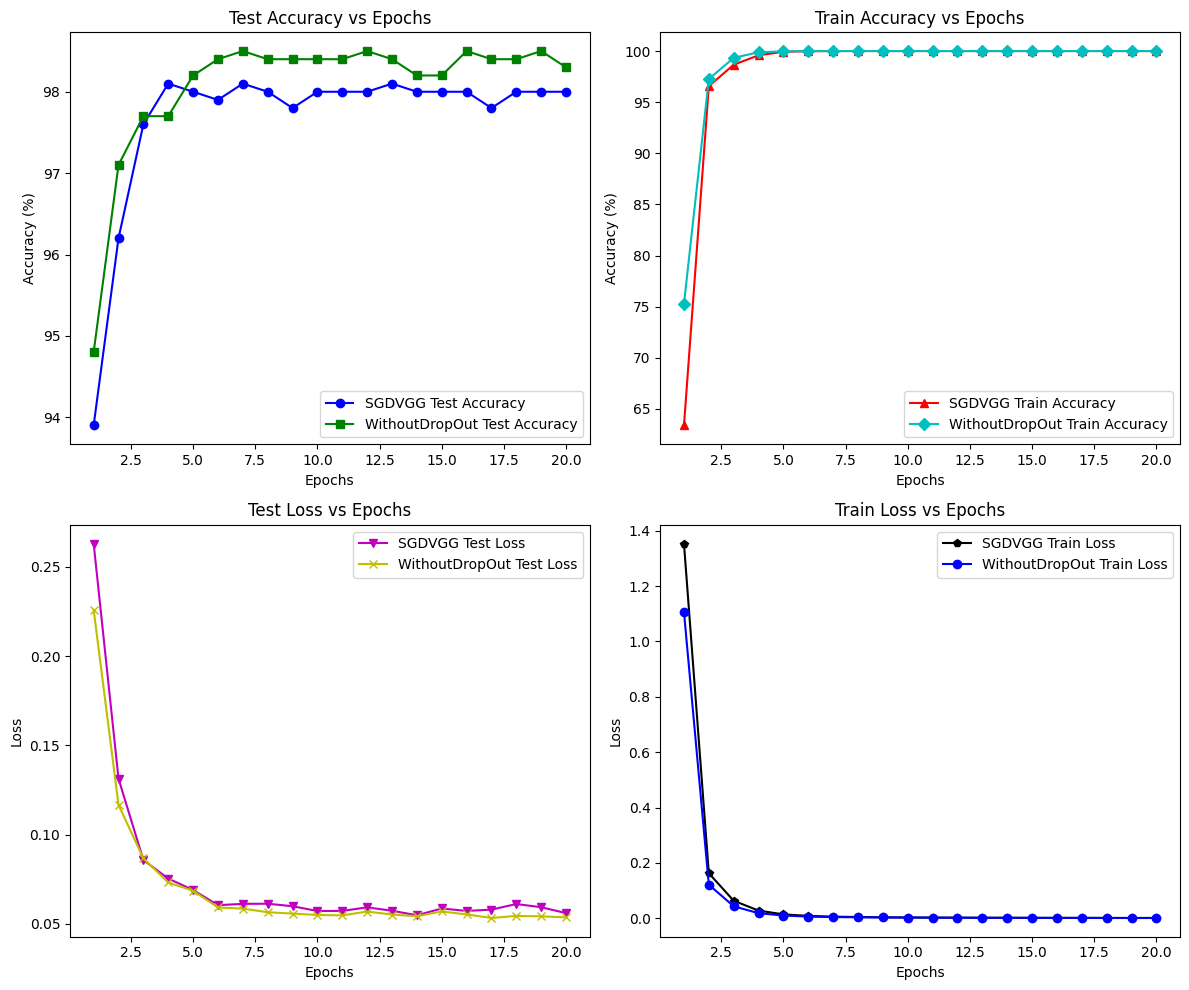

In [ ]:
vggwodropout = VGGWithoutDropout()
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(vggwodropout.parameters(), lr=0.001, momentum=0.9)
num_epochs = 20

metrics_withoutdropout = train(vggwodropout, optimizer, criterion, train_loader1, test_loader1, num_epochs)
torch.save(vggwodropout.state_dict(), "vggwodropout.pth")
plot_comparison_metrics([metrics, metrics_withoutdropout],num_epochs,["SGDVGG","WithoutDropOut"])

#### Comparison of VGG-11 with simpler multilayer perceptron network:

In [ ]:
class MLP(nn.Module):
    def __init__(self):
        super(MLP, self).__init__()
        self.model = nn.Sequential(
            nn.Flatten(), # Flatten the input to a tensor of 784
            nn.Linear(784, 512),
            nn.ReLU(inplace=True),
            nn.Linear(512, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(inplace=True),
            nn.Linear(512, 10)
        )

    def forward(self, x):
        return self.model(x)

In [ ]:
#Same Images but transformation appplied to resize(28)
subset_train_dataset2 = Subset(train_dataset2, training_sample_indices)
subset_test_dataset2 = Subset(test_dataset2, test_sample_indices)

train_loader2 = DataLoader(subset_train_dataset2, batch_size=64, shuffle=True)
test_loader2 = DataLoader(subset_test_dataset2, batch_size=64, shuffle=True)

print(len(subset_train_dataset2))
print(len(subset_test_dataset2))

6000
1000


Epoch [1/20], Train Loss: 2.3098, Train Acc: 14.45%, Test Loss: 2.2994, Test Acc: 15.20%
Epoch [2/20], Train Loss: 2.3106, Train Acc: 14.43%, Test Loss: 2.2961, Test Acc: 15.30%
Epoch [3/20], Train Loss: 2.3102, Train Acc: 14.40%, Test Loss: 2.3010, Test Acc: 14.80%
Epoch [4/20], Train Loss: 2.3119, Train Acc: 14.03%, Test Loss: 2.2998, Test Acc: 14.40%
Epoch [5/20], Train Loss: 2.3107, Train Acc: 14.53%, Test Loss: 2.2964, Test Acc: 14.80%
Epoch [6/20], Train Loss: 2.3109, Train Acc: 14.38%, Test Loss: 2.2955, Test Acc: 14.70%
Epoch [7/20], Train Loss: 2.3097, Train Acc: 14.48%, Test Loss: 2.2995, Test Acc: 15.50%
Epoch [8/20], Train Loss: 2.3099, Train Acc: 14.58%, Test Loss: 2.3018, Test Acc: 14.50%
Epoch [9/20], Train Loss: 2.3101, Train Acc: 14.30%, Test Loss: 2.2977, Test Acc: 15.10%
Epoch [10/20], Train Loss: 2.3108, Train Acc: 13.97%, Test Loss: 2.2999, Test Acc: 15.20%
Epoch [11/20], Train Loss: 2.3108, Train Acc: 14.15%, Test Loss: 2.2982, Test Acc: 15.00%
Epoch [12/20], Trai

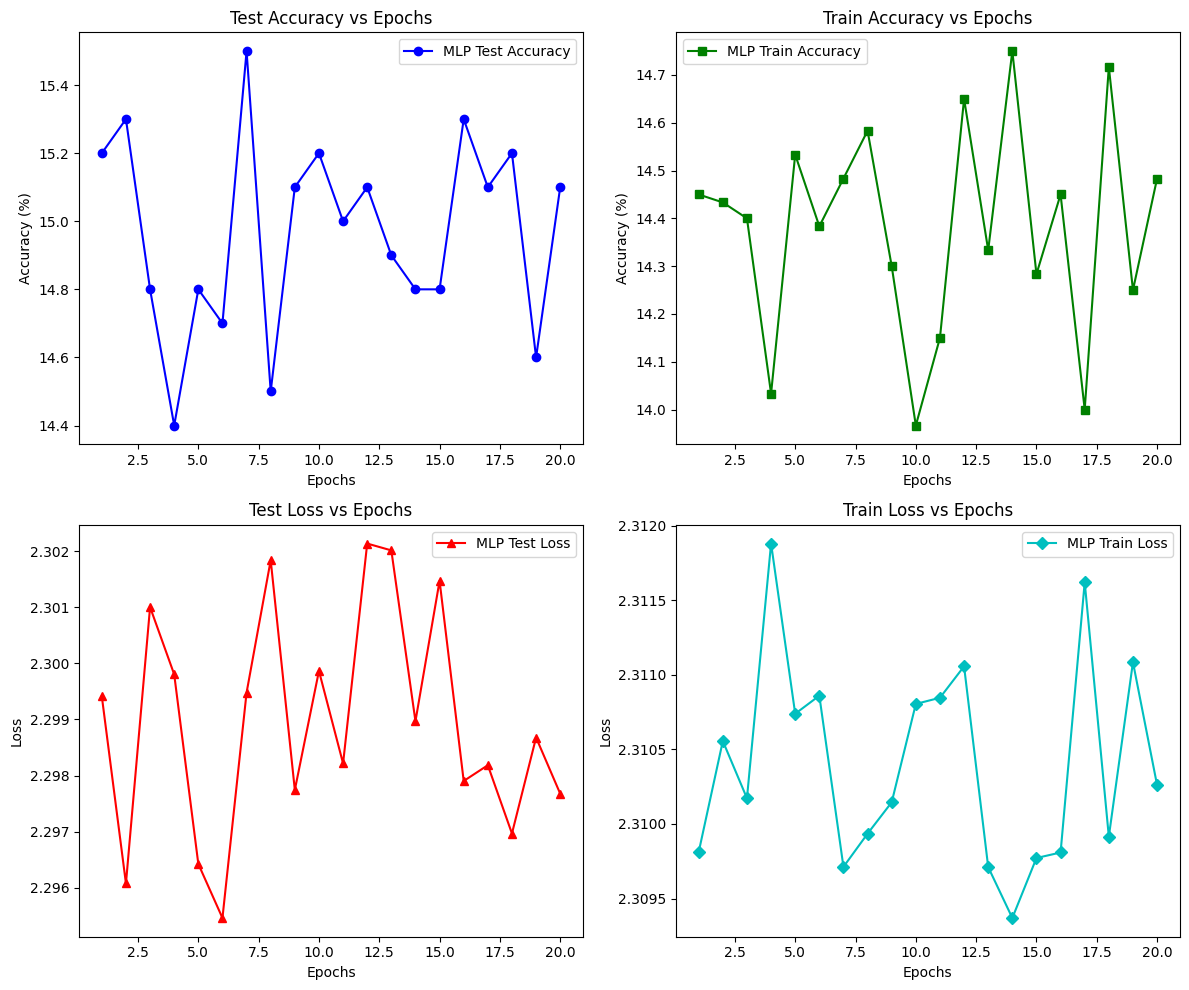

In [ ]:
#Training MLP:
mlpmodel = MLP()
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(vggmodel.parameters(), lr=0.001, momentum=0.9)
num_epochs = 20

mlpmodel_metrics = train(mlpmodel, optimizer, criterion, train_loader2, test_loader2, num_epochs)
torch.save(mlpmodel.state_dict(), "mlpmodel.pth")
plot_comparison_metrics([mlpmodel_metrics],num_epochs,["MLP"])

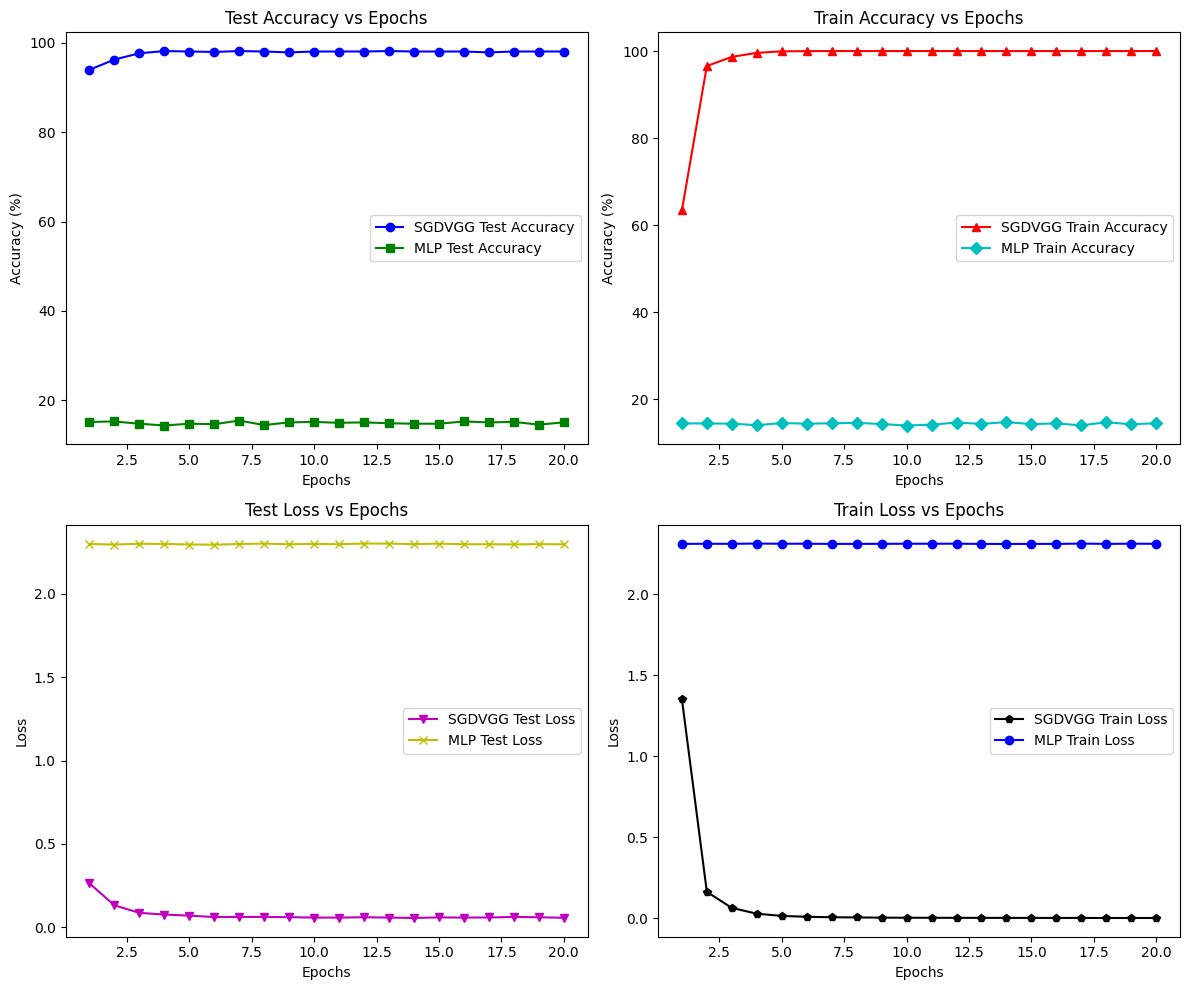

In [ ]:
#3. Comparison with SGD:
plot_comparison_metrics([metrics, mlpmodel_metrics],num_epochs,["SGDVGG","MLP"])

##### Adding more layers to MLP

In [ ]:
class ExtendedMLP(nn.Module):
    def __init__(self):
        super(ExtendedMLP, self).__init__()
        self.model = nn.Sequential(
            nn.Flatten(), # Flatten the input to a tensor of 784
            nn.Linear(784, 512),
            nn.ReLU(inplace=True),
            nn.Linear(512, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(inplace=True),
            nn.Linear(512, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(inplace=True),
            nn.Linear(512, 10)
        )

    def forward(self, x):
        return self.model(x)

Epoch [1/20], Train Loss: 1.0269, Train Acc: 74.23%, Test Loss: 0.5663, Test Acc: 86.00%
Epoch [2/20], Train Loss: 0.3836, Train Acc: 91.27%, Test Loss: 0.4015, Test Acc: 88.90%
Epoch [3/20], Train Loss: 0.2685, Train Acc: 93.75%, Test Loss: 0.3347, Test Acc: 90.20%
Epoch [4/20], Train Loss: 0.2080, Train Acc: 95.22%, Test Loss: 0.2949, Test Acc: 91.40%
Epoch [5/20], Train Loss: 0.1718, Train Acc: 96.05%, Test Loss: 0.2661, Test Acc: 92.50%
Epoch [6/20], Train Loss: 0.1420, Train Acc: 97.20%, Test Loss: 0.2493, Test Acc: 92.70%
Epoch [7/20], Train Loss: 0.1191, Train Acc: 97.58%, Test Loss: 0.2320, Test Acc: 93.00%
Epoch [8/20], Train Loss: 0.0984, Train Acc: 98.33%, Test Loss: 0.2216, Test Acc: 92.80%
Epoch [9/20], Train Loss: 0.0857, Train Acc: 98.72%, Test Loss: 0.2112, Test Acc: 93.20%
Epoch [10/20], Train Loss: 0.0717, Train Acc: 98.93%, Test Loss: 0.1994, Test Acc: 93.40%
Epoch [11/20], Train Loss: 0.0601, Train Acc: 99.38%, Test Loss: 0.2037, Test Acc: 93.10%
Epoch [12/20], Trai

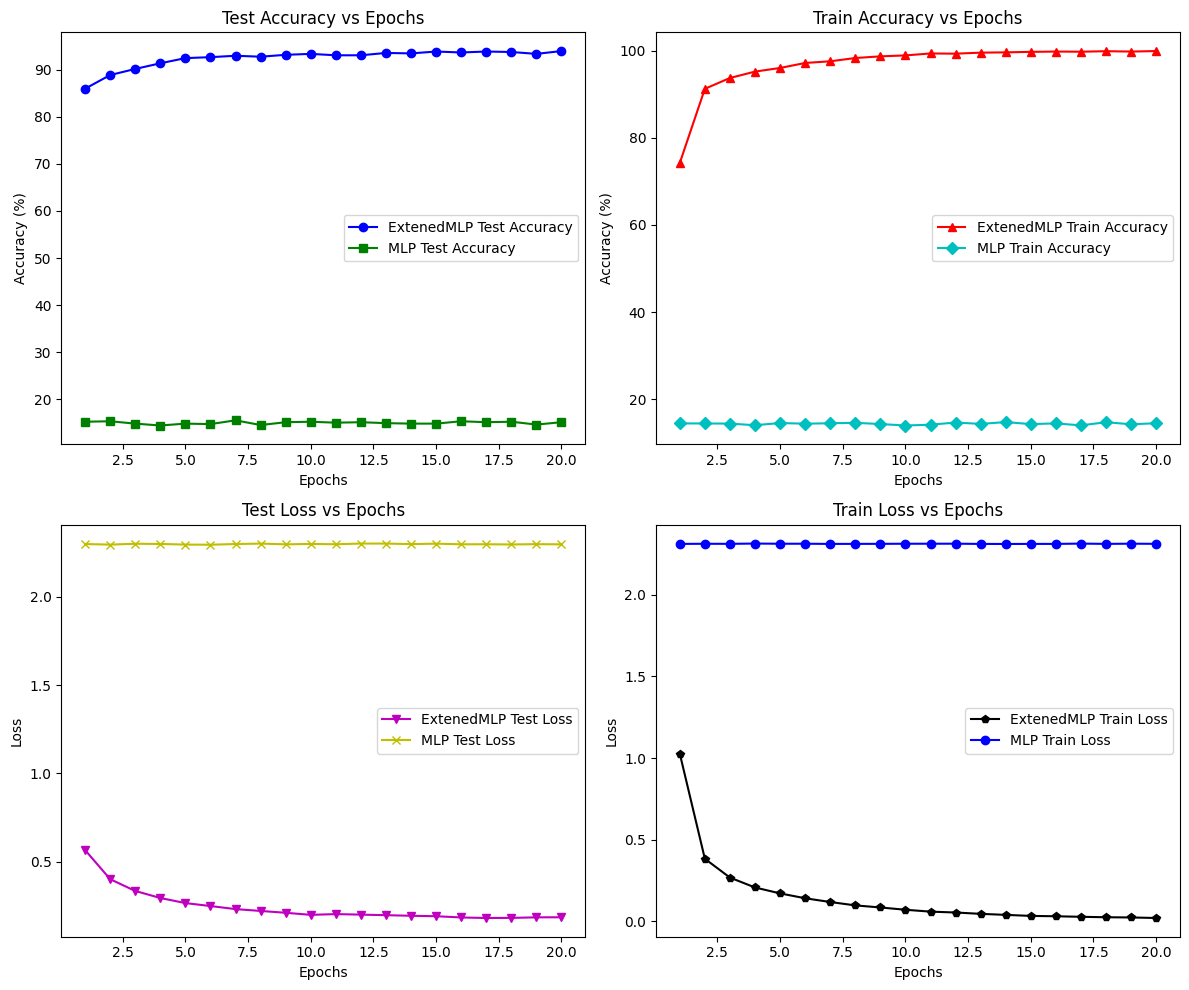

In [ ]:
extendedmlpmodel = ExtendedMLP()
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(extendedmlpmodel.parameters(), lr=0.001, momentum=0.9)
num_epochs = 20

extendedmlpmodel_metrics = train(extendedmlpmodel, optimizer, criterion, train_loader2, test_loader2, num_epochs)
torch.save(extendedmlpmodel.state_dict(), "extendedmlpmodel.pth")
plot_comparison_metrics([extendedmlpmodel_metrics, mlpmodel_metrics],num_epochs,["ExtenedMLP","MLP"])